In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import locale
import regex as re
import math

Gráfico de línea de muertes por traumatismos y por respiratorias, de 2016 a 2020

Heat map mes y año

Correlación ruralidad y tasa de mortalidad

Correlación ruralidad y tasa de mortalidad, por región

Connected dot plot, ordenado por ruralidad 

Cloropletico RM 


In [2]:
print(math.trunc(2.77))
print(math.trunc(8.32))
print(math.trunc(-99.29))

2
8
-99


In [3]:
cols_def=["ANO_DEF","FECHA_DEF","GLOSA_SEXO","EDAD_TIPO","EDAD_CANT","CODIGO_COMUNA_RESIDENCIA",
          "GLOSA_COMUNA_RESIDENCIA","GLOSA_REG_RES","DIAG1","CAPITULO_DIAG1","GLOSA_CAPITULO_DIAG1",
          "CODIGO_GRUPO_DIAG1","GLOSA_GRUPO_DIAG1","CODIGO_CATEGORIA_DIAG1","GLOSA_CATEGORIA_DIAG1",
          "CODIGO_SUBCATEGORIA_DIAG1","GLOSA_SUBCATEGORIA_DIAG1","DIAG2","CAPITULO_DIAG2",
          "GLOSA_CAPITULO_DIAG2","CODIGO_GRUPO_DIAG2","GLOSA_GRUPO_DIAG2","CODIGO_CATEGORIA_DIAG2",
          "GLOSA_CATEGORIA_DIAG2","CODIGO_SUBCATEGORIA_DIAG2","GLOSA_SUBCATEGORIA_DIAG2","LUGAR_DEFUNCION"]
defunciones_com = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)

defunciones_com = defunciones_com[(defunciones_com['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_com = defunciones_com[defunciones_com.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_com.loc[defunciones_com.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_com = defunciones_com[(defunciones_com['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema respiratorio ') | (defunciones_com['GLOSA_CAPITULO_DIAG1']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas')]
defunciones_com = defunciones_com[['CODIGO_COMUNA_RESIDENCIA','ANO_DEF','GLOSA_COMUNA_RESIDENCIA','GLOSA_CAPITULO_DIAG1','FECHA_DEF']]
defunciones_com = (defunciones_com.groupby(by=['CODIGO_COMUNA_RESIDENCIA','GLOSA_COMUNA_RESIDENCIA','ANO_DEF','GLOSA_CAPITULO_DIAG1'])
               .count()
               .reset_index()
               .rename(columns = {'CODIGO_COMUNA_RESIDENCIA':'Comuna',
                                  'GLOSA_COMUNA_RESIDENCIA' : 'Glosa Comuna',
                                  'GLOSA_CAPITULO_DIAG1':'causa',
                                  'ANO_DEF':'anio',
                                  'FECHA_DEF':'n_def'}))

proy_pob_com = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_com = (proy_pob_com[['Comuna','Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021'
               
           }))
proy_pob_com = (pd.melt(proy_pob_com,id_vars='Comuna',
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob'
           })
           .groupby(['Comuna','anio'])
           .sum()
           .reset_index())

proy_pob_com_rur = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_com_rur = (proy_pob_com_rur[['Comuna','Area (1=Urbano 2=Rural)','Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021',
                              'Area (1=Urbano 2=Rural)':'area'
               
           }))
proy_pob_com_rur = (pd.melt(proy_pob_com_rur,id_vars=['Comuna','area'],
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob_rur'
           })
           .groupby(['Comuna','anio','area'])
           .sum()
           .reset_index())
proy_pob_com_rur = proy_pob_com_rur[proy_pob_com_rur['area']==2]

proy_pob_com['anio'] = proy_pob_com['anio'].astype('int64')
proy_pob_com_rur['anio'] = proy_pob_com_rur['anio'].astype('int64')

tasa_def_com = (defunciones_com.merge(proy_pob_com,how='left',on=['Comuna','anio'])
.merge(proy_pob_com_rur[['Comuna','anio','pob_rur']],how='left',on=['Comuna','anio']))
tasa_def_com['tasa_def_com'] = tasa_def_com['n_def']/tasa_def_com['pob']*100000
tasa_def_com['tasa_rur'] = tasa_def_com['pob_rur']/tasa_def_com['pob']*100
tasa_def_com['region'] = np.where(tasa_def_com['Comuna']>=10000, tasa_def_com['Comuna'].astype(str).str[0:2], tasa_def_com['Comuna'].astype(str).str[0])
tasa_def_com['region'] = tasa_def_com['region'].astype('int64')

In [4]:
tasa_def_com

Comuna Glosa Comuna  anio  \
0       1101      Iquique  2016   
1       1101      Iquique  2016   
2       1101      Iquique  2017   
3       1101      Iquique  2017   
4       1101      Iquique  2018   
...      ...          ...   ...   
3929   16305  San Nicolás  2019   
3930   16305  San Nicolás  2020   
3931   16305  San Nicolás  2020   
3932   16305  San Nicolás  2021   
3933   16305  San Nicolás  2021   

                                                  causa  n_def     pob  \
0                Enfermedades del sistema respiratorio      76  199592   
1     Traumatismos, envenenamientos y algunas otras ...     98  199592   
2                Enfermedades del sistema respiratorio      91  202891   
3     Traumatismos, envenenamientos y algunas otras ...     75  202891   
4                Enfermedades del sistema respiratorio     102  209409   
...                                                 ...    ...     ...   
3929  Traumatismos, envenenamientos y algunas otras ...      6   12068   
3930             Enfermedades del sistema respiratorio      14   12172   
3931  Traumatismos, envenenamientos y algunas otras ...      9   12172   
3932             Enfermedades del sistema respiratorio      13   12261   
3933  Traumatismos, envenenamientos y algunas otras ...     11   12261   

      pob_rur  tasa_def_com   tasa_rur  region  
0        2679     38.077678   1.342238       1  
1        2679     49.100164   1.342238       1  
2        3361     44.851669   1.656555       1  
3        3361     36.965661   1.656555       1  
4        3473     48.708508   1.658477       1  
...       ...           ...        ...     ...  
3929     6847     49.718263  56.736825      16  
3930     6881    115.018074  56.531384      16  
3931     6881     73.940191  56.531384      16  
3932     6911    106.027241  56.365712      16  
3933     6911     89.715358  56.365712      16  

[3934 rows x 10 columns]

In [5]:
cols_def=["ANO_DEF","FECHA_DEF","GLOSA_SEXO","EDAD_TIPO","EDAD_CANT","CODIGO_COMUNA_RESIDENCIA",
          "GLOSA_COMUNA_RESIDENCIA","GLOSA_REG_RES","DIAG1","CAPITULO_DIAG1","GLOSA_CAPITULO_DIAG1",
          "CODIGO_GRUPO_DIAG1","GLOSA_GRUPO_DIAG1","CODIGO_CATEGORIA_DIAG1","GLOSA_CATEGORIA_DIAG1",
          "CODIGO_SUBCATEGORIA_DIAG1","GLOSA_SUBCATEGORIA_DIAG1","DIAG2","CAPITULO_DIAG2",
          "GLOSA_CAPITULO_DIAG2","CODIGO_GRUPO_DIAG2","GLOSA_GRUPO_DIAG2","CODIGO_CATEGORIA_DIAG2",
          "GLOSA_CATEGORIA_DIAG2","CODIGO_SUBCATEGORIA_DIAG2","GLOSA_SUBCATEGORIA_DIAG2","LUGAR_DEFUNCION"]
defunciones_nac = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)

defunciones_nac = defunciones_nac[(defunciones_nac['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_nac = defunciones_nac[defunciones_nac.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_nac.loc[defunciones_nac.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_nac = defunciones_nac[(defunciones_nac['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema respiratorio ') | (defunciones_nac['GLOSA_CAPITULO_DIAG1']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas')]
defunciones_nac = defunciones_nac[['ANO_DEF','GLOSA_CAPITULO_DIAG1','FECHA_DEF']]
defunciones_nac = (defunciones_nac.groupby(by=['ANO_DEF','GLOSA_CAPITULO_DIAG1'])
               .count()
               .reset_index()
               .rename(columns = {'GLOSA_CAPITULO_DIAG1':'causa',
                                  'ANO_DEF':'anio',
                                  'FECHA_DEF':'n_def'}))

proy_pob_nac = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_nac = (proy_pob_nac[['Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021'
               
           }))
proy_pob_nac = (pd.melt(proy_pob_nac,
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob'
           })
           .groupby(['anio'])
           .sum()
           .reset_index())
proy_pob_nac['anio'] = proy_pob_nac['anio'].astype('int64')

tasa_def_nac = (defunciones_nac.merge(proy_pob_nac,how='left',on=['anio']))
tasa_def_nac['tasa_def_nac'] = tasa_def_nac['n_def']/tasa_def_nac['pob']*100000


In [6]:
tab1 = tasa_def_nac.pivot_table(values="tasa_def_nac",index=["causa"],columns = "anio",aggfunc=sum)

In [7]:
tab1

anio                                                     2016      2017  \
causa                                                                     
Enfermedades del sistema respiratorio               54.202237  58.96567   
Traumatismos, envenenamientos y algunas otras c...  42.786025  41.14187   

anio                                                     2018       2019  \
causa                                                                      
Enfermedades del sistema respiratorio               65.211114  72.558975   
Traumatismos, envenenamientos y algunas otras c...  41.106253  42.209184   

anio                                                      2020        2021  
causa                                                                       
Enfermedades del sistema respiratorio               165.029748  196.586474  
Traumatismos, envenenamientos y algunas otras c...   40.332382   39.540891

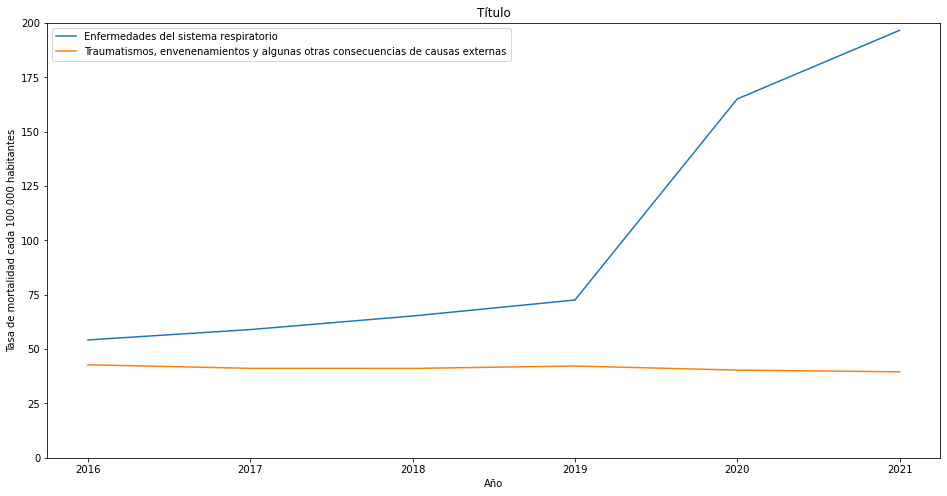

In [8]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab1.index:
    tab1.loc[year].plot.line(ax=ax)

plt.title("Título") 
plt.xlabel("Año")
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes")
plt.legend()
plt.ylim(0, 200)

plt.show()

In [36]:
cols_def=["ANO_DEF","FECHA_DEF","GLOSA_SEXO","EDAD_TIPO","EDAD_CANT","CODIGO_COMUNA_RESIDENCIA",
          "GLOSA_COMUNA_RESIDENCIA","GLOSA_REG_RES","DIAG1","CAPITULO_DIAG1","GLOSA_CAPITULO_DIAG1",
          "CODIGO_GRUPO_DIAG1","GLOSA_GRUPO_DIAG1","CODIGO_CATEGORIA_DIAG1","GLOSA_CATEGORIA_DIAG1",
          "CODIGO_SUBCATEGORIA_DIAG1","GLOSA_SUBCATEGORIA_DIAG1","DIAG2","CAPITULO_DIAG2",
          "GLOSA_CAPITULO_DIAG2","CODIGO_GRUPO_DIAG2","GLOSA_GRUPO_DIAG2","CODIGO_CATEGORIA_DIAG2",
          "GLOSA_CATEGORIA_DIAG2","CODIGO_SUBCATEGORIA_DIAG2","GLOSA_SUBCATEGORIA_DIAG2","LUGAR_DEFUNCION"]
defunciones_mes = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)
defunciones_mes = defunciones_mes[(defunciones_mes['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_mes = defunciones_mes[defunciones_mes.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_mes.loc[defunciones_mes.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_mes = pd.DataFrame(defunciones_mes[(defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema respiratorio ') | (defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas')])
defunciones_mes['fecha'] = pd.to_datetime(defunciones_mes['FECHA_DEF'], format='%Y-%m-%d')
defunciones_mes['mes'] = defunciones_mes['fecha'].dt.strftime('%m')
defunciones_mes['region'] = np.where(defunciones_mes['CODIGO_COMUNA_RESIDENCIA']>=10000, defunciones_mes['CODIGO_COMUNA_RESIDENCIA'].astype(str).str[0:2], defunciones_mes['CODIGO_COMUNA_RESIDENCIA'].astype(str).str[0])
defunciones_mes['region'] = defunciones_mes['region'].astype('int64')

In [37]:
defunciones_mes_ce = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas']
defunciones_mes_ce = defunciones_mes_ce[['ANO_DEF','mes','FECHA_DEF']]
defunciones_mes_ce = defunciones_mes_ce.groupby(by=['ANO_DEF','mes']).count().reset_index()
defunciones_mes_ce = (defunciones_mes_ce.pivot_table(values='FECHA_DEF',index=["mes"], columns = "ANO_DEF",aggfunc=sum).dropna())
defunciones_mes_res = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema respiratorio ']
defunciones_mes_res = defunciones_mes_res[['ANO_DEF','mes','FECHA_DEF']]
defunciones_mes_res = defunciones_mes_res.groupby(by=['ANO_DEF','mes']).count().reset_index()
defunciones_mes_res = (defunciones_mes_res.pivot_table(values='FECHA_DEF',index=["mes"], columns = "ANO_DEF",aggfunc=sum).dropna())

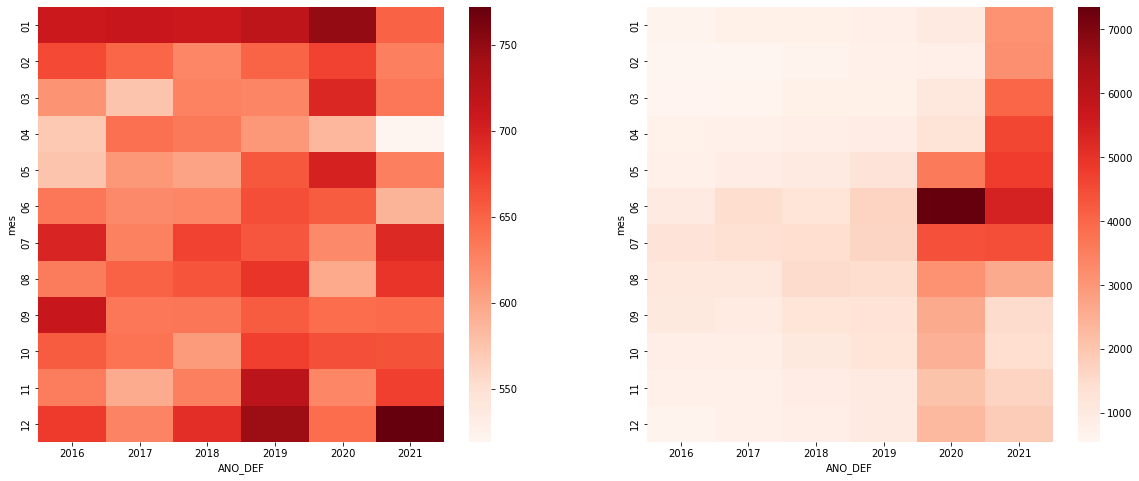

In [38]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(defunciones_mes_ce, ax=ax[0], cmap='Reds')
sns.heatmap(defunciones_mes_res, ax=ax[1], cmap='Reds')
plt.show()

In [64]:
defunciones_mes_ce_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas']
defunciones_mes_ce_reg = defunciones_mes_ce_reg[['ANO_DEF','mes','region','FECHA_DEF']]
defunciones_mes_ce_reg = defunciones_mes_ce_reg.groupby(by=['ANO_DEF','mes','region']).count().reset_index()
defunciones_mes_ce_reg = (defunciones_mes_ce_reg.pivot_table(values='FECHA_DEF',index=["mes",'region'], columns = "ANO_DEF",aggfunc=sum).dropna())
defunciones_mes_ce_reg = defunciones_mes_ce_reg.reset_index()
defunciones_mes_res_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema respiratorio ']
defunciones_mes_res_reg = defunciones_mes_res_reg[['ANO_DEF','mes','region','FECHA_DEF']]
defunciones_mes_res_reg = defunciones_mes_res_reg.groupby(by=['ANO_DEF','mes','region']).count().reset_index()
defunciones_mes_res_reg = (defunciones_mes_res_reg.pivot_table(values='FECHA_DEF',index=["mes",'region'], columns = "ANO_DEF",aggfunc=sum).dropna())
defunciones_mes_res_reg = defunciones_mes_res_reg.reset_index()

In [53]:
regiones = defunciones_mes_ce_reg['region'].unique()
nregiones = len(regiones)
cols = 4
rows = int(nregiones/cols)
regiones

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [66]:
def plot_region(region, ax, df):
    data = (
        df[df['region'] == region]
            .drop(['region'], axis=1)
            .set_index('mes')
        )
    sns.heatmap(data, ax=ax, cmap='Reds', yticklabels=False)
    ax.set_title(region, fontsize=24)

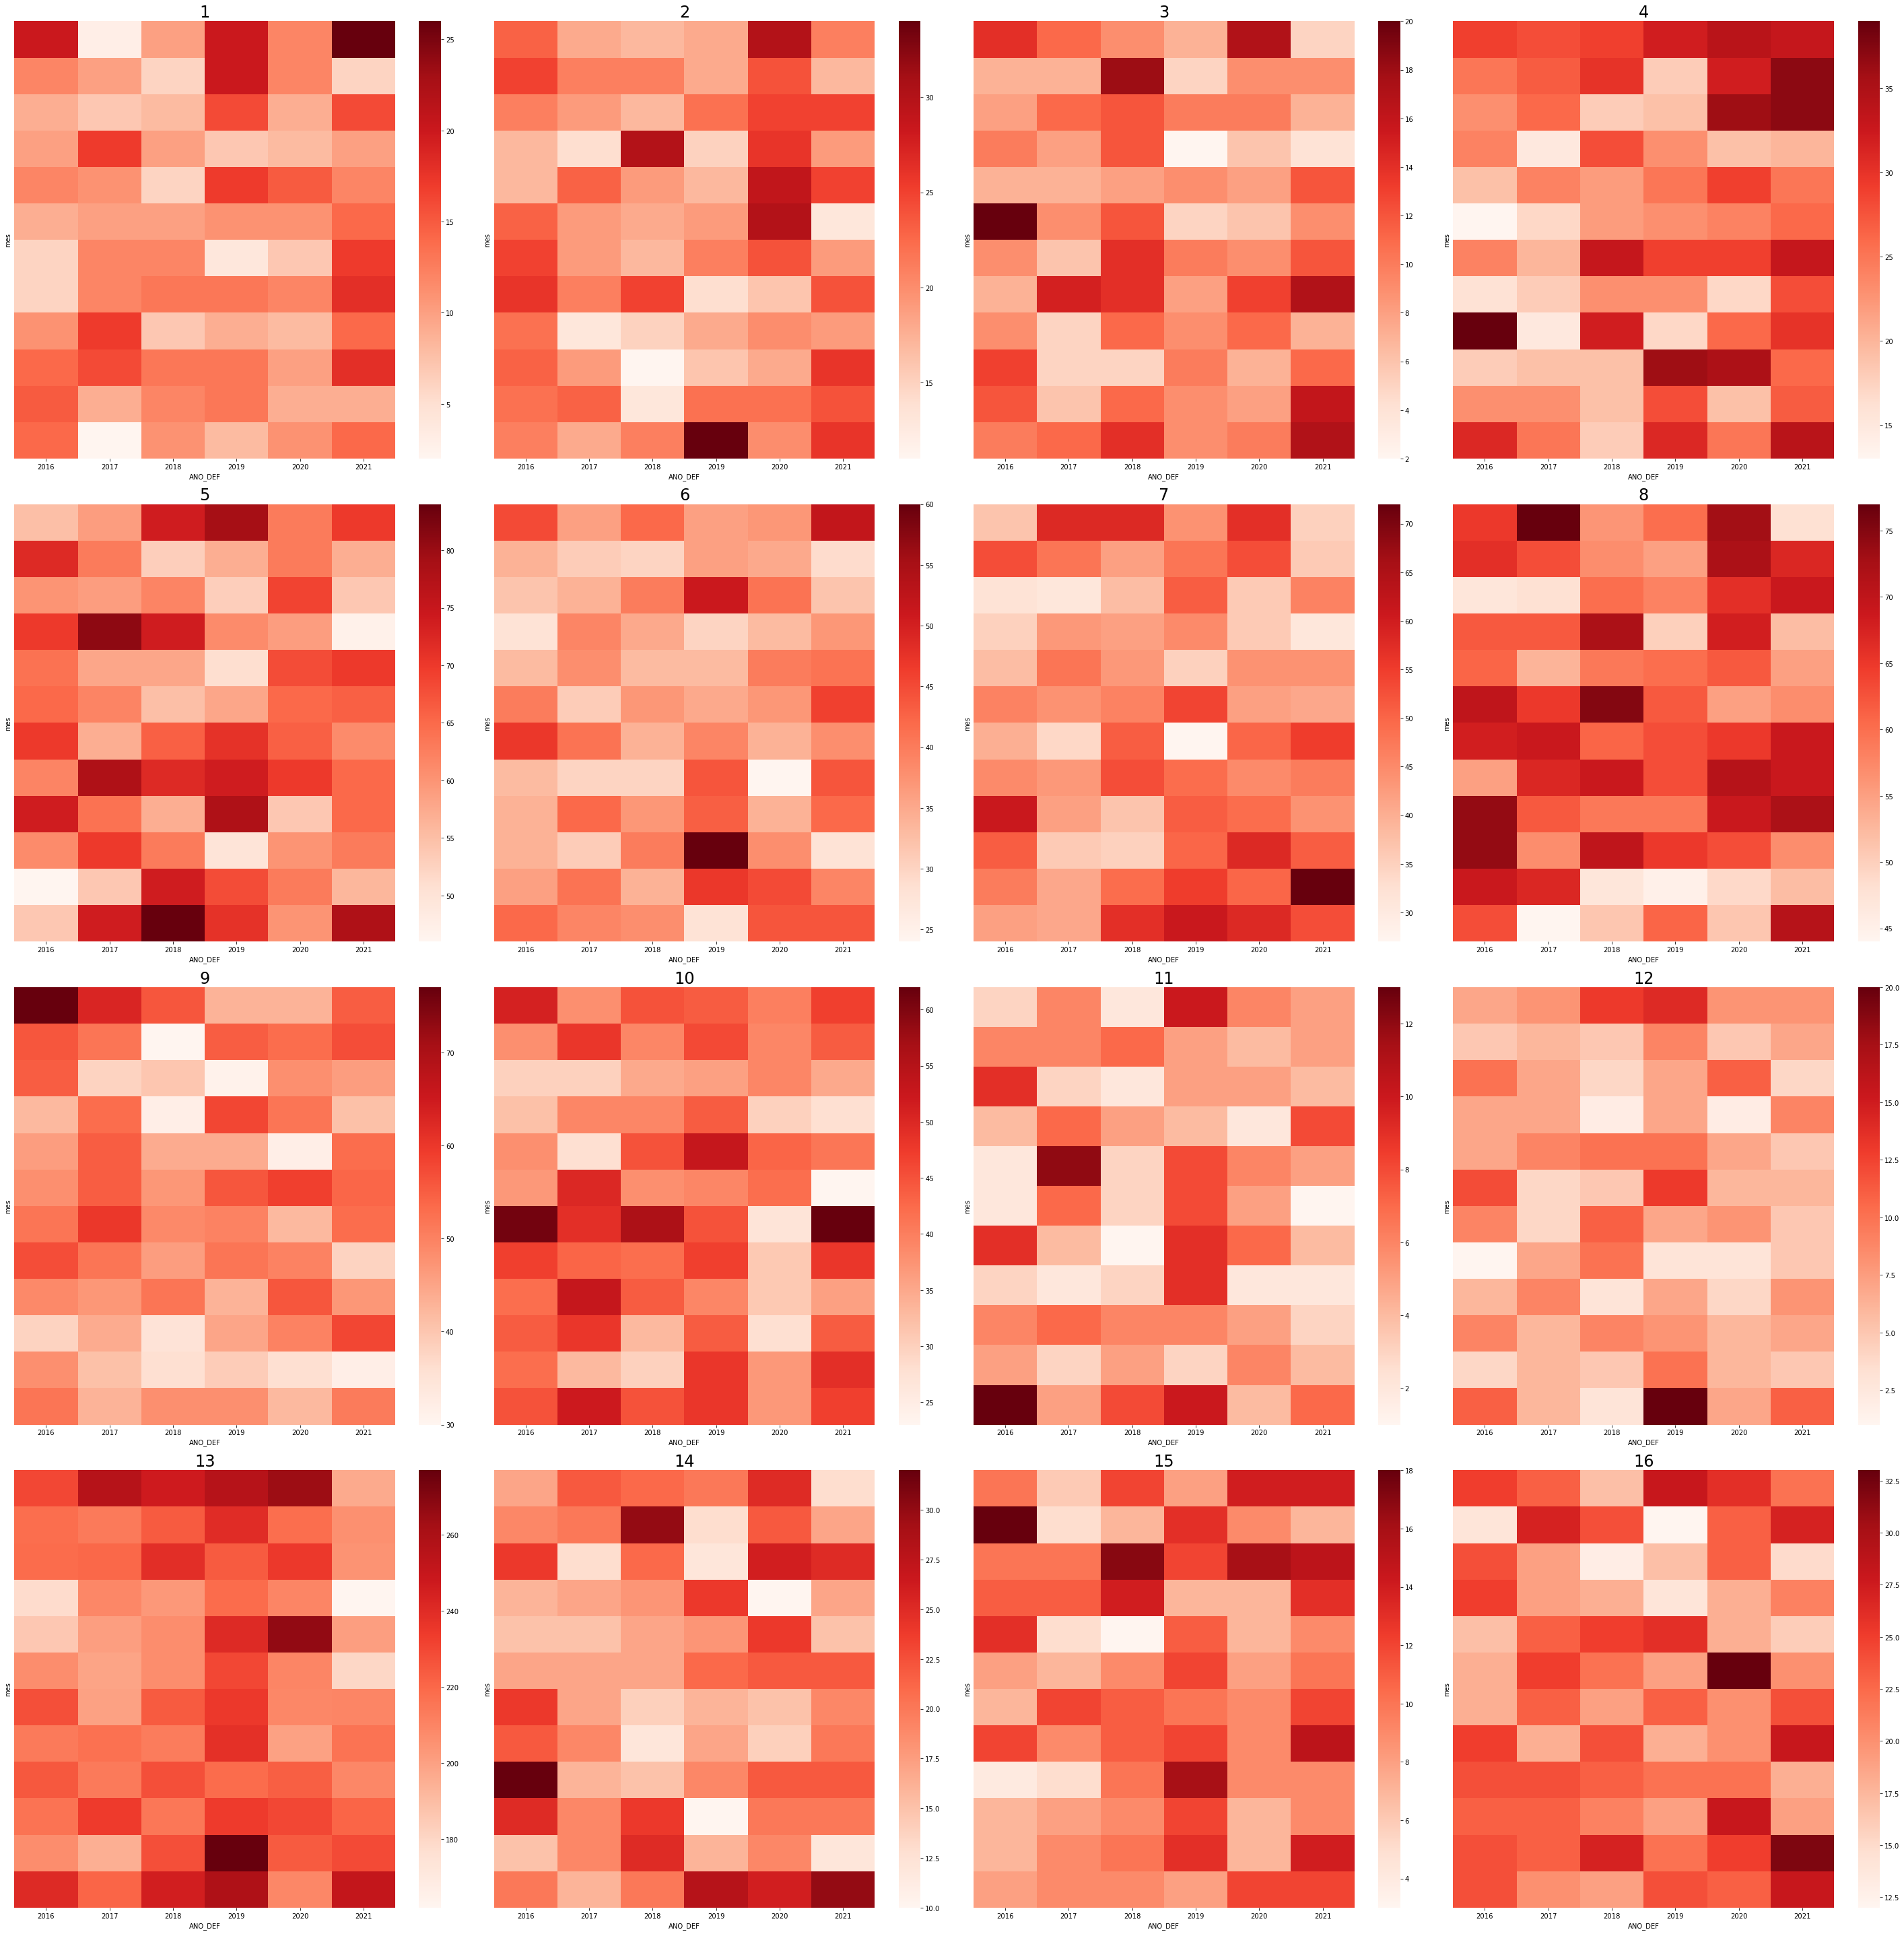

In [67]:
fig, ax = plt.subplots(rows, cols, figsize=(40,40))

for idx_region, region in enumerate(regiones):
    row = int(idx_region / cols)
    col = idx_region % cols
    plot_region(region, ax[row][col],defunciones_mes_ce_reg)
    
fig.tight_layout()

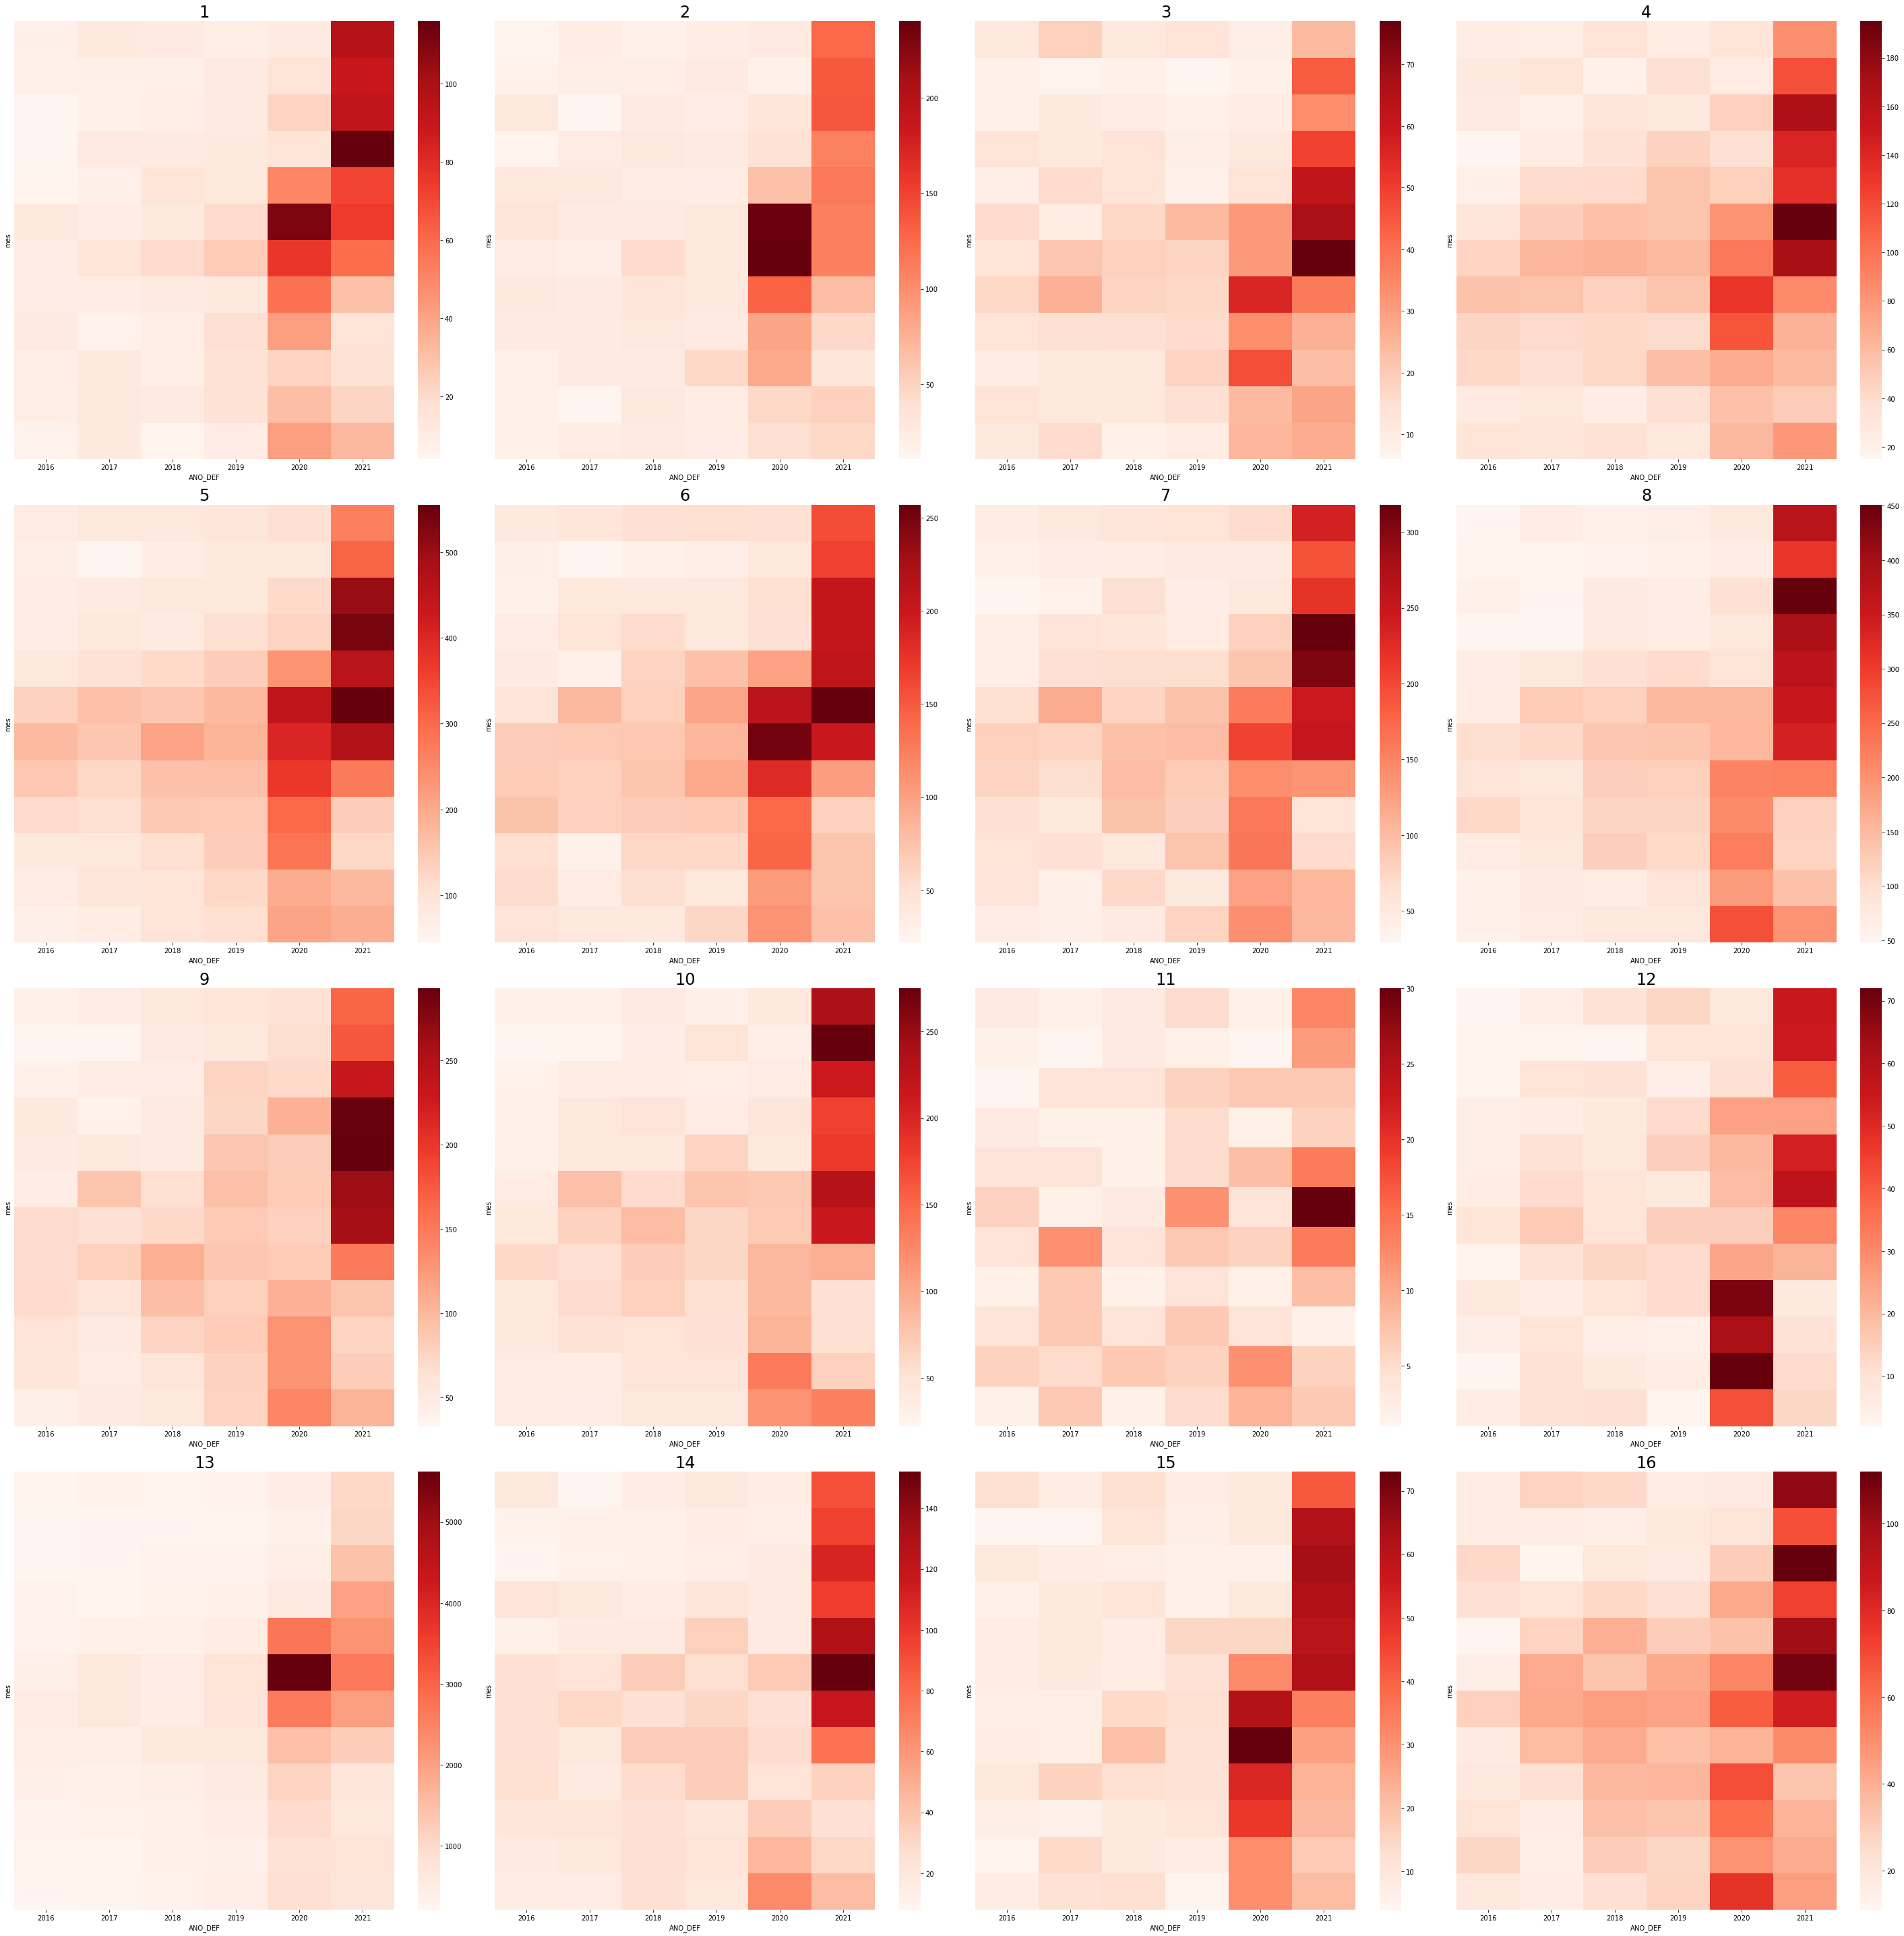

In [68]:
fig, ax = plt.subplots(rows, cols, figsize=(40,40))

for idx_region, region in enumerate(regiones):
    row = int(idx_region / cols)
    col = idx_region % cols
    plot_region(region, ax[row][col],defunciones_mes_res_reg)
    
fig.tight_layout()

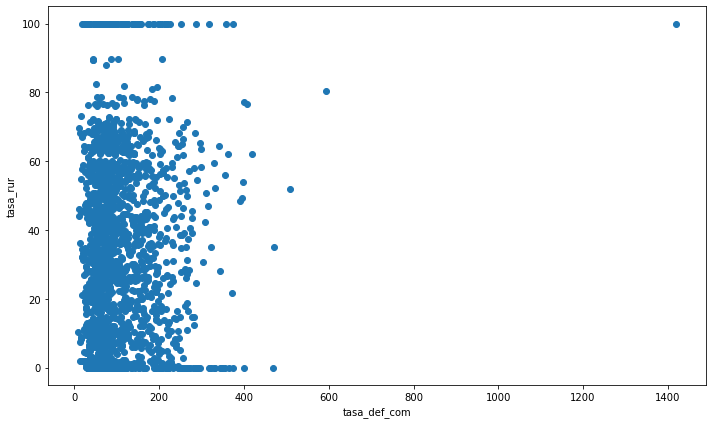

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
tasa_def_com_res = tasa_def_com[tasa_def_com['causa']=='Enfermedades del sistema respiratorio ']
ax.scatter(tasa_def_com_res['tasa_def_com'], tasa_def_com_res['tasa_rur'])
ax.set_xlabel('tasa_def_com')
ax.set_ylabel('tasa_rur')

fig.tight_layout()

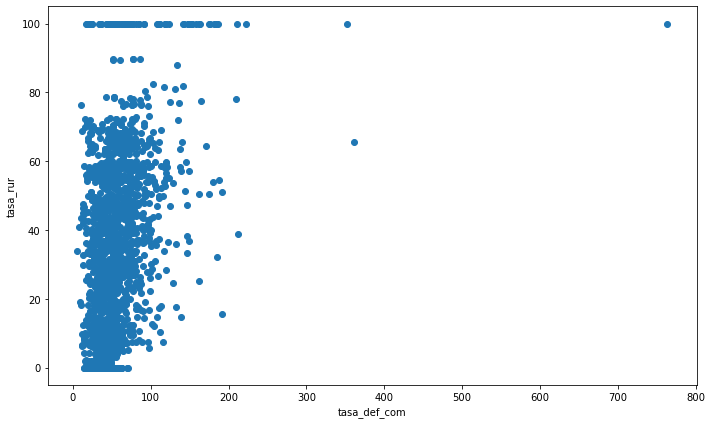

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
tasa_def_com_ce = tasa_def_com[tasa_def_com['causa']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas']
ax.scatter(tasa_def_com_ce['tasa_def_com'], tasa_def_com_ce['tasa_rur'])
ax.set_xlabel('tasa_def_com')
ax.set_ylabel('tasa_rur')

fig.tight_layout()

/var/folders/zp/qf4mwdy15mdclj5m29nhrj1m0000gn/T/ipykernel_89835/803080653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasa_def_com_res['color'] = tasa_def_com_res['region'].map({


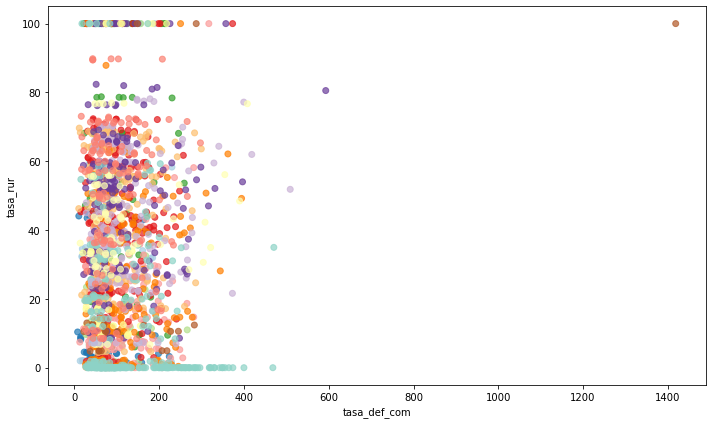

In [20]:
tasa_def_com_res['color'] = tasa_def_com_res['region'].map({
    1: '#a6cee3',
    2: '#1f78b4',
    3: '#b2df8a',
    4: '#33a02c',
    5: '#fb9a99',
    6: '#e31a1c',
    7: '#fdbf6f',
    8: '#ff7f00',
    9: '#cab2d6',
    10:'#6a3d9a',
    11:'#ffff99',
    12:'#b15928',
    13:'#8dd3c7',
    14:'#ffffb3',
    15:'#bebada',
    16:'#fb8072'
})
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tasa_def_com_res['tasa_def_com'], tasa_def_com_res['tasa_rur'],
           c=tasa_def_com_res['color'],alpha=0.7)
ax.set_xlabel('tasa_def_com')
ax.set_ylabel('tasa_rur')

fig.tight_layout()

/var/folders/zp/qf4mwdy15mdclj5m29nhrj1m0000gn/T/ipykernel_89835/1790914716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasa_def_com_res['color'] = tasa_def_com_res['region'].map({


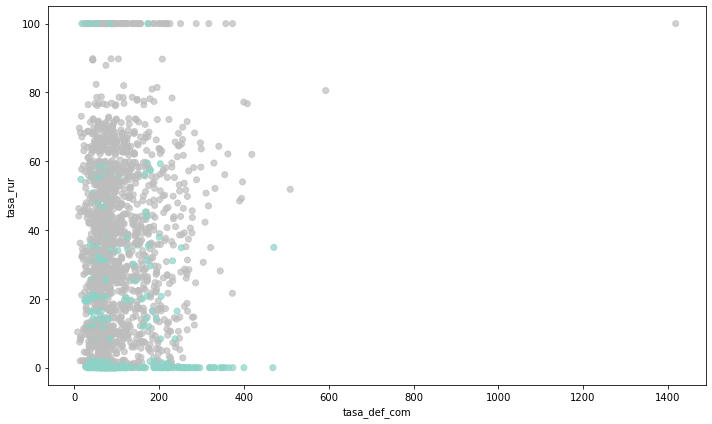

In [23]:
tasa_def_com_res['color'] = tasa_def_com_res['region'].map({
    1: '#bdbdbd',
    2: '#bdbdbd',
    3: '#bdbdbd',
    4: '#bdbdbd',
    5: '#bdbdbd',
    6: '#bdbdbd',
    7: '#bdbdbd',
    8: '#bdbdbd',
    9: '#bdbdbd',
    10:'#bdbdbd',
    11:'#bdbdbd',
    12:'#bdbdbd',
    13:'#8dd3c7',
    14:'#bdbdbd',
    15:'#bdbdbd',
    16:'#bdbdbd'
})
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tasa_def_com_res['tasa_def_com'], tasa_def_com_res['tasa_rur'],
           c=tasa_def_com_res['color'],alpha=0.7)
ax.set_xlabel('tasa_def_com')
ax.set_ylabel('tasa_rur')

fig.tight_layout()


/var/folders/zp/qf4mwdy15mdclj5m29nhrj1m0000gn/T/ipykernel_89835/1364704764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasa_def_com_res['color'] = tasa_def_com_res['region'].map({


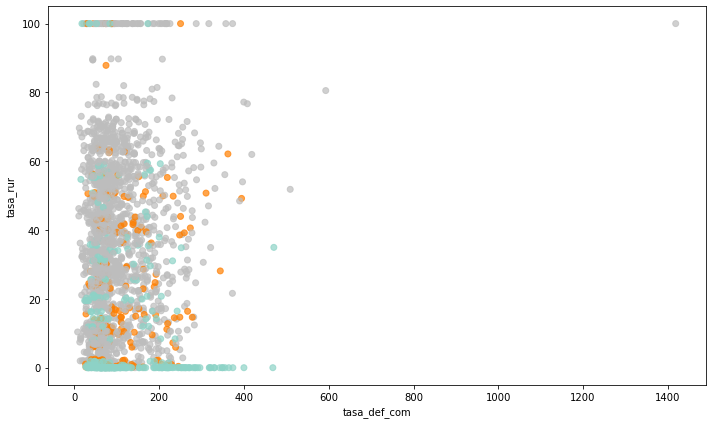

In [24]:
tasa_def_com_res['color'] = tasa_def_com_res['region'].map({
    1: '#bdbdbd',
    2: '#bdbdbd',
    3: '#bdbdbd',
    4: '#bdbdbd',
    5: '#bdbdbd',
    6: '#bdbdbd',
    7: '#bdbdbd',
    8: '#ff7f00',
    9: '#bdbdbd',
    10:'#bdbdbd',
    11:'#bdbdbd',
    12:'#bdbdbd',
    13:'#8dd3c7',
    14:'#bdbdbd',
    15:'#bdbdbd',
    16:'#bdbdbd'
})
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tasa_def_com_res['tasa_def_com'], tasa_def_com_res['tasa_rur'],
           c=tasa_def_com_res['color'],alpha=0.7)
ax.set_xlabel('tasa_def_com')
ax.set_ylabel('tasa_rur')

fig.tight_layout()


In [ ]:
regiones

In [95]:
tasa_def_com_2017_2021 = tasa_def_com[(tasa_def_com["anio"]==2017) | (tasa_def_com["anio"]==2021)]
tasa_def_com_2017_2021 = tasa_def_com_2017_2021[tasa_def_com_2017_2021['causa']=='Enfermedades del sistema respiratorio ']
tasa_def_com_2017_2021.loc[tasa_def_com_2017_2021.anio == 2017, 'anio'] ='anio_2017'
tasa_def_com_2017_2021.loc[tasa_def_com_2017_2021.anio == 2021, 'anio'] ='anio_2021'
tab3 = (tasa_def_com_2017_2021
        .pivot_table("tasa_def_com",index=["Glosa Comuna"], columns = "anio",aggfunc=sum))
tab3['delta'] = tab3["anio_2021"] / tab3["anio_2017"] - 1
tasa_rur_2021 = tasa_def_com[(tasa_def_com["anio"]==2021) & (tasa_def_com_2017_2021['causa']=='Enfermedades del sistema respiratorio ')]
tasa_rur_2021 = tasa_rur_2021[['Glosa Comuna','tasa_rur']].set_index('Glosa Comuna')
tab3 = pd.merge(tab3, tasa_rur_2021, left_index=True, right_index=True).sort_values('tasa_rur')

In [96]:
tab3

anio_2017    anio_2021      delta  tasa_rur
Glosa Comuna                                              
Ñuñoa          71.153543   161.048850   1.263399       0.0
Santiago       29.787901   108.645221   2.647294       0.0
San Ramón      84.130460   399.920946   3.753581       0.0
San Miguel     96.823998   279.899149   1.890803       0.0
San Joaquín    75.474736   290.745251   2.852220       0.0
...                  ...          ...        ...       ...
Río Hurtado    91.449474   206.374685   1.256707     100.0
Río Ibáñez    112.443778   184.842884   0.643869     100.0
San Gregorio         NaN   148.367953        NaN     100.0
Navidad        30.075188   373.134328  11.406716     100.0
Antártica            NaN  1418.439716        NaN     100.0

[335 rows x 4 columns]

In [97]:

plt.figure(figsize=(100,150))

y_range = np.arange(1, len(tab3.index) + 1)
colors = np.where(tab3['anio_2021'] > tab3['anio_2017'], '#d9d9d9', '#d57883')

plt.hlines(y=y_range, xmin=tab3['anio_2017'], xmax=tab3['anio_2021'],
           color=colors, lw=20)
plt.scatter(tab3['anio_2017'], y_range, color='#0096d7', s=200, label='2017', zorder=3)
plt.scatter(tab3['anio_2021'], y_range, color='#003953', s=200 , label='2021', zorder=3)

plt.yticks(y_range, tab3.index,fontsize=40)
plt.title("prueba", loc='left',fontsize=50)
plt.xlim(0, 1450)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab3.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["anio_2017"], row["anio_2021"]) + 4, y - 0.25))
plt.legend(ncol=1, bbox_to_anchor=(1., 0.45, 0.2, 0.2), loc='upper center', frameon=True)
plt.show()


In [98]:
tasa_def_com_2019_2020 = tasa_def_com[(tasa_def_com["anio"]==2019) | (tasa_def_com["anio"]==2020)]
tasa_def_com_2019_2020 = tasa_def_com_2019_2020[tasa_def_com_2019_2020['causa']=='Enfermedades del sistema respiratorio ']
tasa_def_com_2019_2020.loc[tasa_def_com_2019_2020.anio == 2019, 'anio'] ='anio_2019'
tasa_def_com_2019_2020.loc[tasa_def_com_2019_2020.anio == 2020, 'anio'] ='anio_2020'
tab3 = (tasa_def_com_2019_2020
        .pivot_table("tasa_def_com",index=["Glosa Comuna"], columns = "anio",aggfunc=sum))
tab3['delta'] = tab3["anio_2020"] / tab3["anio_2019"] - 1
tasa_rur_2020 = tasa_def_com[(tasa_def_com["anio"]==2020) & (tasa_def_com_2019_2020['causa']=='Enfermedades del sistema respiratorio ')]
tasa_rur_2020 = tasa_rur_2020[['Glosa Comuna','tasa_rur']].set_index('Glosa Comuna')
tab3 = pd.merge(tab3, tasa_rur_2020, left_index=True, right_index=True).sort_values('tasa_rur')

In [117]:

plt.figure(figsize=(100,150))

y_range = np.arange(1, len(tab3.index) + 1)
colors = np.where(tab3['anio_2020'] > tab3['anio_2019'], '#d9d9d9', '#d57883')

plt.hlines(y=y_range, xmin=tab3['anio_2019'], xmax=tab3['anio_2020'],
           color=colors, lw=20)
plt.scatter(tab3['anio_2019'], y_range, color='#0096d7', s=200, label='2019', zorder=3)
plt.scatter(tab3['anio_2020'], y_range, color='#003953', s=200 , label='2020', zorder=3)

plt.yticks(y_range, tab3.index,fontsize=40)
plt.title("prueba", loc='left',fontsize=50)
plt.xlim(0, 500)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab3.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["anio_2019"], row["anio_2020"]) + 4, y - 0.25))
plt.legend(ncol=1,bbox_to_anchor=(1., 0.45, 0.2, 0.2), loc='upper center', frameon=True)
plt.show()
